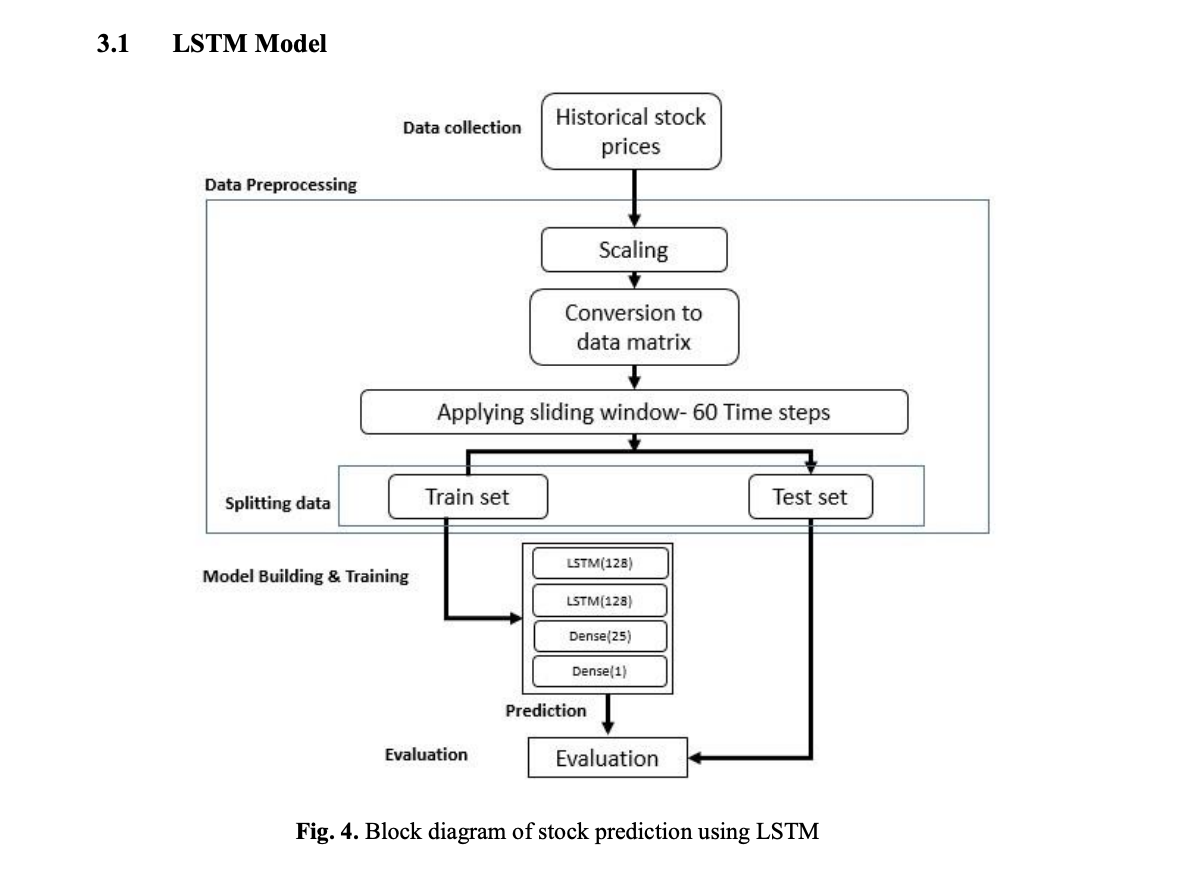

In [1]:
# Step 1: Install and import necessary libraries
#### First, you need to install the necessary libraries. You can do this using pip.
!pip install pandas yfinance seaborn matplotlib tensorflow keras scikit-learn plotly
  

In [2]:
#### Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
# Download the data using yfinance.
data = yf.download('^NSEI', start='2021-01-01', end='2024-11-01')
data.columns = data.columns.get_level_values(0)  

[*********************100%***********************]  1 of 1 completed


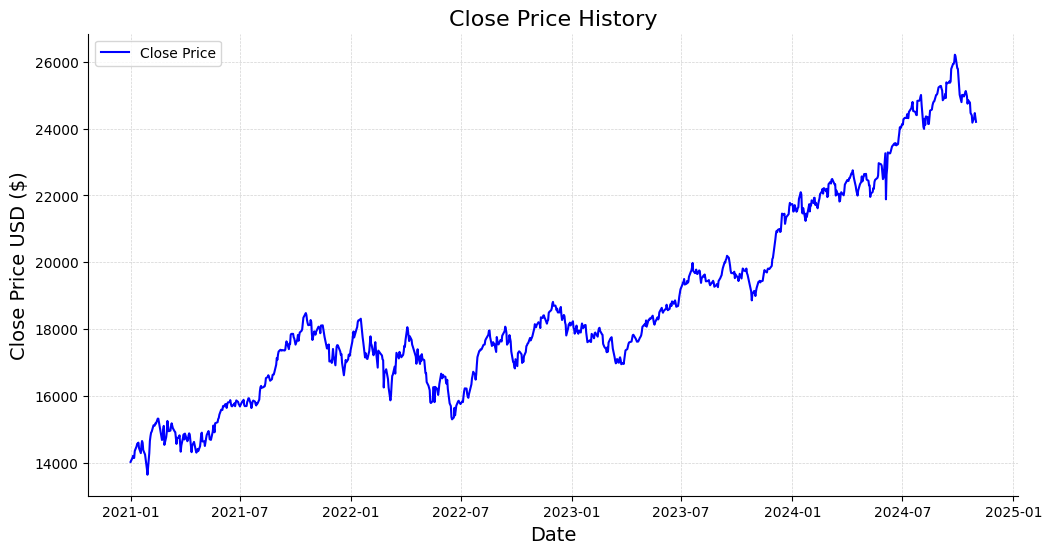

In [33]:
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(data.index, data['Close'], color='blue', label='Close Price')  # Plot the line

# Title and Labels
plt.title('Close Price History', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)

# Grid
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)

# Background color (optional, default is white)
plt.gca().set_facecolor('white')  # Plot area
plt.gcf().set_facecolor('white')  # Entire figure

# Optional: Remove top and right spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Display the plot
plt.legend()
plt.show()

In [ ]:
# Step 3: Prepare the data for LSTM
#### Before feeding the data into an LSTM model, we need to scale it and create a training data set:

# Create a new dataframe with only the 'Close' column
data = data.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * .95 ))

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Create the training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])


In [6]:
# Step 4: Build and train the LSTM model
  # Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Model checkpoint: Save the best model during training
model_checkpoint = ModelCheckpoint(
    'best_model.keras',  # Filepath to save the model
    monitor='val_loss',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    verbose=1
)

#  Train the model with validation split and callbacks
history = model.fit(
    x_train, y_train,
    validation_split=0.2,  # Use 20% of the training data for validation
    batch_size=1,
    epochs=25,
    callbacks=[early_stop, model_checkpoint],
    verbose=2
)


/opt/anaconda3/envs/Conda_310/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25

Epoch 1: val_loss improved from inf to 0.00055, saving model to best_model.keras
672/672 - 13s - 19ms/step - loss: 0.0014 - val_loss: 5.4920e-04
Epoch 2/25

Epoch 2: val_loss did not improve from 0.00055
672/672 - 12s - 18ms/step - loss: 5.8580e-04 - val_loss: 0.0038
Epoch 3/25

Epoch 3: val_loss improved from 0.00055 to 0.00030, saving model to best_model.keras
672/672 - 12s - 18ms/step - loss: 4.5474e-04 - val_loss: 3.0088e-04
Epoch 4/25

Epoch 4: val_loss did not improve from 0.00030
672/672 - 12s - 18ms/step - loss: 3.4242e-04 - val_loss: 0.0023
Epoch 5/25

Epoch 5: val_loss did not improve from 0.00030
672/672 - 12s - 18ms/step - loss: 3.2697e-04 - val_loss: 3.9371e-04
Epoch 6/25

Epoch 6: val_loss did not improve from 0.00030
672/672 - 12s - 18ms/step - loss: 3.6816e-04 - val_loss: 3.8364e-04
Epoch 7/25

Epoch 7: val_loss did not improve from 0.00030
672/672 - 12s - 18ms/step - loss: 2.7182e-04 - val_loss: 0.0020
Epoch 8/25

Epoch 8: val_loss did not improve from 0.00

In [ ]:
# Step 5: Test the model accuracy on existing data and visualise tested data
#### After training the model, we can test its accuracy on the existing data:

# Prepare test data
test_data = scaled_data[training_data_len - 60:, :]

# Prepare the input sequences and target values for testing
x_test, y_test = [], []
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
    
# Convert the input sequences and target values to NumPy arrays
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Use the model to make predictions on the test data
predictions = model.predict(x_test)

# Transform the predictions and actual values back to their original scales
predictions = scaler.inverse_transform(predictions)
y_test = np.asarray(y_test).reshape(-1,1)
y_test = scaler.inverse_transform(y_test)

# Calculate the root mean square error (rmse)
rmse = np.sqrt(np.mean(((predictions - y_test)**2)))

print(f'rmse:{rmse}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
rmse:213.80521799242015


/var/folders/ws/v15jk6j56z90j1tz393rgysw0000gn/T/ipykernel_26689/3848311908.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


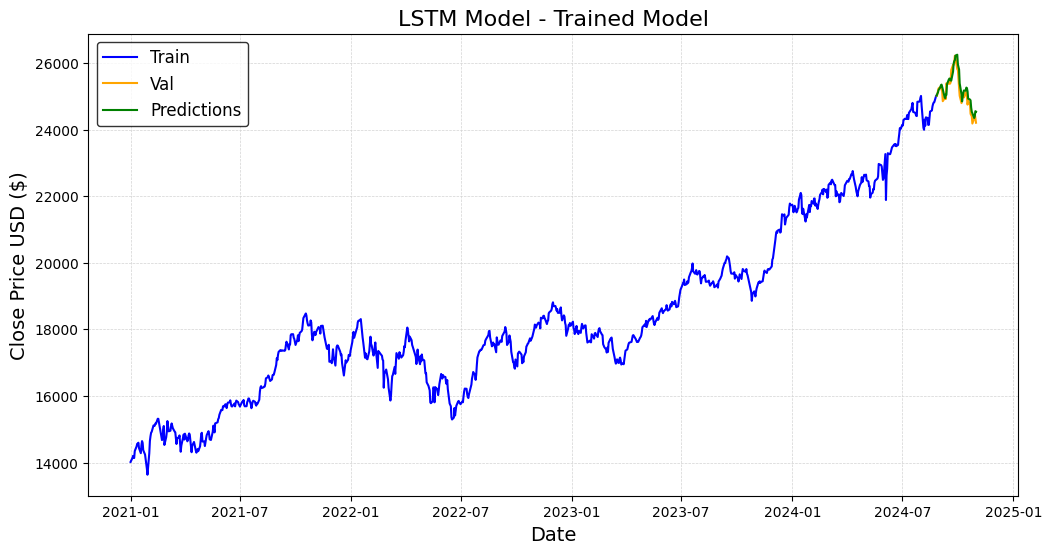

In [ ]:
# Visualise the trained model with tested data 
#### Finally, we can plot the data to see how well the model fits the existing data:
# Splitting the Data and adding Predictions to Validation Data:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions


plt.figure(figsize=(12, 6))  # Set the figure size

# Plot the 'Close' price for train, valid, and predictions
plt.plot(train.index, train['Close'], label='Train', color='blue')
plt.plot(valid.index, valid['Close'], label='Val', color='orange')
plt.plot(valid.index, valid['Predictions'], label='Predictions', color='green')

# Add title and axis labels
plt.title('LSTM Model - Trained Model', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)

# Add grid
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)

# Customize the legend
plt.legend(loc='upper left', fontsize=12, frameon=True, edgecolor='black')

# Optional: Set background colors
plt.gca().set_facecolor('white')  # Plot area background
plt.gcf().set_facecolor('white')  # Entire figure background

# Display the plot
plt.show()


In [9]:
# Step 6: Predict Future Stock Price
# Get the last 60 day closing price
last_60_days = dataset[-60:]

# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days.reshape(-1, 1))

# Create an empty list
X_test = []

# Append the past 60 days
X_test.append(last_60_days_scaled)

# Convert the X_test data set to a numpy array
X_test = np.array(X_test)

# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price
pred_price = model.predict(X_test)

# Undo the scaling
pred_prices = scaler.inverse_transform(np.array(pred_price).reshape(-1, 1))

# Print the predicted prices
print(pred_prices)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[[24406.4]]


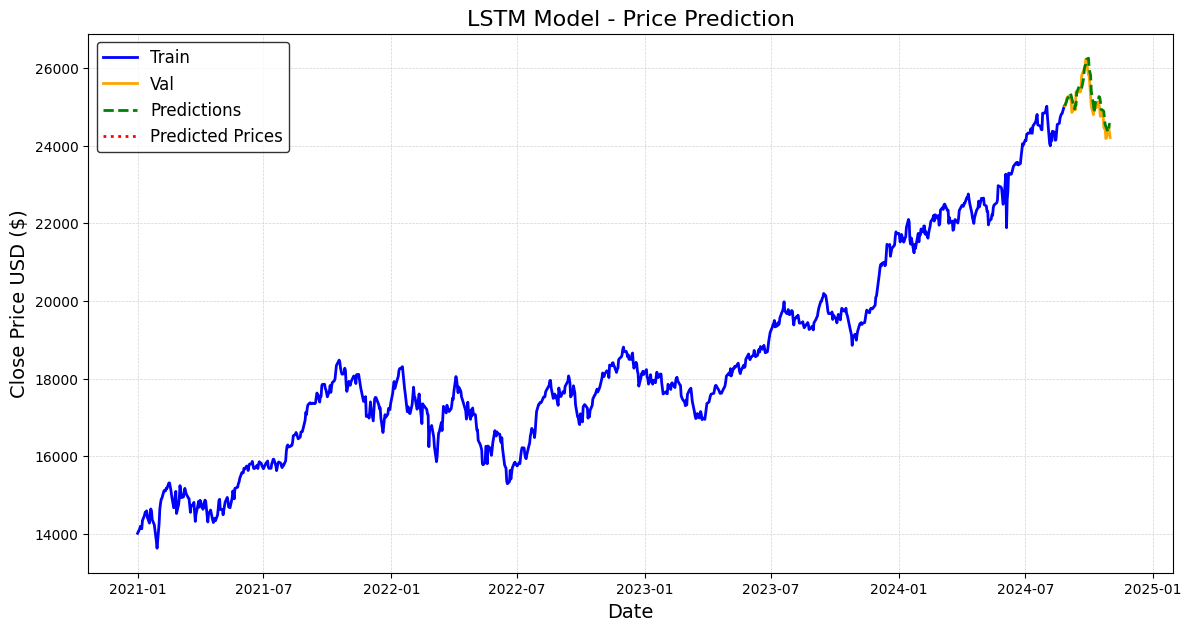

In [10]:
plt.figure(figsize=(14, 7))  # Set figure size

# Plot train data
plt.plot(train.index, train['Close'], label='Train', color='blue', linewidth=2)

# Plot validation data
plt.plot(valid.index, valid['Close'], label='Val', color='orange', linewidth=2)

# Plot predictions on validation data
plt.plot(valid.index, valid['Predictions'], label='Predictions', color='green', linestyle='--', linewidth=2)

# Generate date range for predicted prices
dates = pd.date_range(start=pd.Timestamp.today(), periods=len(pred_prices))

# Plot predicted prices
plt.plot(dates, pred_prices.flatten(), label='Predicted Prices', color='red', linestyle=':', linewidth=2)

# Add title and labels
plt.title('LSTM Model - Price Prediction', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)

# Add grid
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)

# Customize the legend
plt.legend(loc='upper left', fontsize=12, frameon=True, edgecolor='black')

# Optional: Set background colors
plt.gca().set_facecolor('white')  # Plot area background
plt.gcf().set_facecolor('white')  # Entire figure background

# Show the plot
plt.show()


In [30]:
df_valid = pd.DataFrame(valid)
df_valid = df_valid.reset_index()


df_valid['diff'] = df_valid['Predictions']-df_valid['Close']
df_valid['pct_diff'] = df_valid['diff']/df_valid['Close']*100

print(df_valid)

                        Date         Close   Predictions        diff  pct_diff
0  2024-08-27 00:00:00+00:00  25017.750000  25020.974609    3.224609  0.012889
1  2024-08-28 00:00:00+00:00  25052.349609  25080.011719   27.662109  0.110417
2  2024-08-29 00:00:00+00:00  25151.949219  25112.208984  -39.740234 -0.158001
3  2024-08-30 00:00:00+00:00  25235.900391  25185.414062  -50.486328 -0.200058
4  2024-09-02 00:00:00+00:00  25278.699219  25274.283203   -4.416016 -0.017469
5  2024-09-03 00:00:00+00:00  25279.849609  25335.634766   55.785156  0.220670
6  2024-09-04 00:00:00+00:00  25198.699219  25349.671875  150.972656  0.599129
7  2024-09-05 00:00:00+00:00  25145.099609  25285.359375  140.259766  0.557802
8  2024-09-06 00:00:00+00:00  24852.150391  25211.121094  358.970703  1.444425
9  2024-09-09 00:00:00+00:00  24936.400391  24979.568359   43.167969  0.173112
10 2024-09-10 00:00:00+00:00  25041.099609  24943.226562  -97.873047 -0.390850
11 2024-09-11 00:00:00+00:00  24918.449219  25050.90

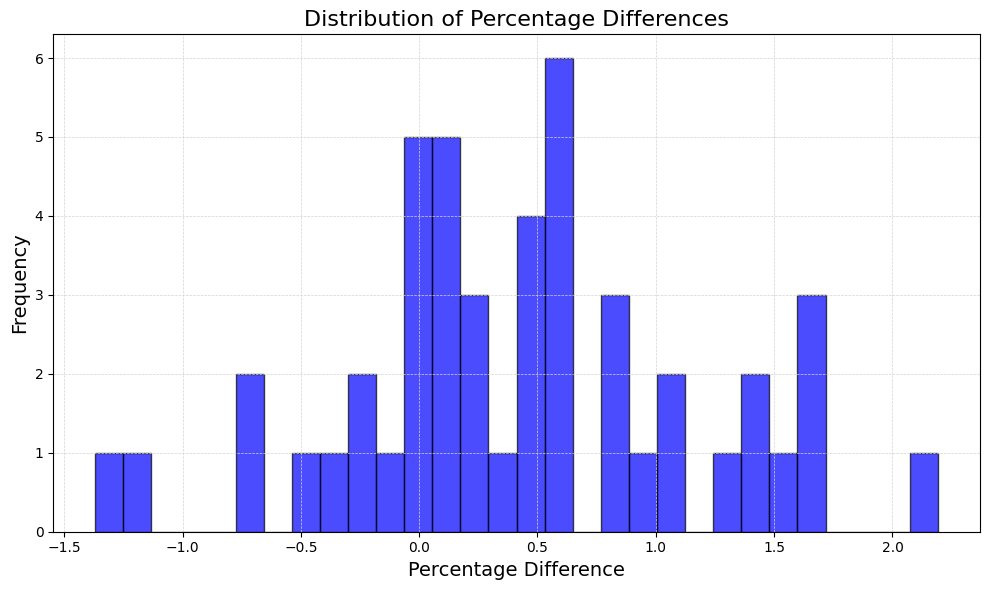

In [31]:

# Plot histogram
plt.figure(figsize=(10, 6))  # Set figure size
plt.hist(df_valid['pct_diff'], bins=30, color='blue', alpha=0.7, edgecolor='black')

# Add title and labels
plt.title('Distribution of Percentage Differences', fontsize=16)
plt.xlabel('Percentage Difference', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Customize grid and style
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()
